# OPeNDAP Access in Python to Derive Climate Normals and Anomalies of Daymet netCDF4 Yearly Data
*Author: ORNL DAAC*
<br>
*Date: February 12, 2018*
<br>
*Contact for [ORNL DAAC](https://daac.ornl.gov/): uso@daac.ornl.gov*

##### Keywords:  ORNL DAAC, Daymet, weather estimates, Anomalies, Normals, THREDDS, OPeNDAP, Earthdata, `pydap`

## Overview
In this tutorial, we will explore using the `pydap` package to plot `Daymet` data. Specifically, we will calculate anomalies and normals for a weather estimate such as `tmin`, `tmax`, and `prcp`. To learn more about how to use Jupyter Notebooks, check out this [`YouTube` video](https://www.youtube.com/watch?v=JImOfVHQtYc).

![](output.png)

## Source Data
A spatial subset of the North American Daymet dataset daily data; https://daymet.ornl.gov . In this example, we will access the data from [this ORNL DAAC's THREDDS server.](https://thredds.daac.ornl.gov/thredds/catalogs/ornldaac/Regional_and_Global_Data/DAYMET_COLLECTIONS/DAYMET_COLLECTIONS.html)

## Prerequisites:
Python 2.7 or greater. Python modules: `pydap`, `basemap`, `matplotlib`

## Procedure

### 1. Import Dependencies
Let's import all the libraries that we will need. ***If the following cell does not execute correctly***, then you need to install any package that is missing as seen in the error message. For example, you may need to install `basemap` or `pydap`. Depending upon which `Python` environment you are using, you can install these packages with commands such as:

`pip install pydap`

or 

`conda install pydap`

Now, run the following cell.

In [1]:
from mpl_toolkits.basemap import Basemap # plotting data on map
from IPython.display import display      # iPython Widgets
from pydap.client import open_url        # pydap package
import matplotlib.pyplot as plt          # base plotting package
import ipywidgets as widgets             # iPython Widgets
import datetime as datetime              # datetime package
import numpy as np                       # numerical processing
import warnings                          # supress warnings
import time                              # to find processing time


warnings.filterwarnings('ignore')
%matplotlib inline

### 2. What are Normals and Anomalies?
It is important to note that both normals and anomalies can be calculated at different spacial resolutions. For the following definitions, let's assume we are interested in a single lat-lon location. Later on in the notebook, we will be calculating normals and anomalies for a `tile` of Daymet data ($2$ x $2$ degree space).
#### Normals
As defined by the [`NOAA`](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/climate-normals/1981-2010-normals-data), a climate **normal** of a particular weather estimate (such as minimum temperature) is a 30 year average from 1981 to 2010. *For example*, the April normal for minimum temperature would be calculated as follows:

$$Normal=\frac{1}{30} \sum_{i=1981}^{2010} \left( \frac{1}{30} \sum_{j=1}^{30} tmin_{i,j}\right)$$

where $i$ represents the year and $j$ is the day in April. For example, $tmin_{ 1990,22}$ is the specific $tmin$ value for April 22, 1990. The $\frac{1}{30}$ factors come from computing averages. ***Note that there are more comprehensive formulas for calculating Normals; this is the simplest form of using variable means only.***

Normals can be calculated for monthly averages (as seen above), yearly averages, or even seasonal averages.  A yearly normal is simply all the data for a specific variable average over 30 years (what we will do in this Jupyter Notebook). As long as the same time range is selected for each year, a normal can be calculated.

#### Anomalies
Anomalies are the deviations from the Normal over a specified time range that is within the time range of the Normal. An example of this will be shown in the notebook.

### 3. Accesing THREDDS Server
The `Daymet` data we will use is hosted on a `THREDDS` server. To learn more about accessing `Daymet` data from a `THREDDS` server, click [here](https://daymet.ornl.gov/dataaccess.html#THREDDS).

The server we will be working with in this notebook can be found [here](https://thredds.daac.ornl.gov/thredds/catalogs/ornldaac/Regional_and_Global_Data/DAYMET_COLLECTIONS/DAYMET_COLLECTIONS.html). We will be using the tiled data.  In this notebook, let's look at tile id `11371`. This tile is centered at 
* lat = 37°
* lon = -119°

In order to understand the layout of this server, let's navigate the directory as follows:

1. Click on this [link](https://thredds.daac.ornl.gov/thredds/catalogs/ornldaac/Regional_and_Global_Data/DAYMET_COLLECTIONS/DAYMET_COLLECTIONS.html)
2. From here, enter the directory: [`Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1 (tiles)/`](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2129/tiles/catalog.html)
3. Enter the directory: [`1983/`](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2129/tiles/1983/catalog.html)
4. Enter the directory: [`11371_1983/`](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2129/tiles/1983/11371_1983/catalog.html)
5. Click on [`tmin.nc`](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2129/tiles/1983/11371_1983/catalog.html?dataset=2129t/1983/11371_1983/tmin.nc)

From here, you can see that access to the data is available through an OpenDAP data access form. Click on this [`OpenDAP link`](https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/tiles/1983/11371_1983/tmin.nc.html)

#### OPeNDAP Dataset Access Form
On this page, you will notice a data URL. In this case, it should be: <br>
`https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/tiles/1983/11371_1983/tmin.nc`

The `pydap` package will use the URL to pull data into this Jupyter Notebook. <br>

If we wanted the data for `2016` instead of `1983`, we can simply replace all instances of `1983` with `2016` in the URL as follows:
`https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/tiles/2016/11371_2016/tmin.nc`

If we wanted the data for a different tile, simply replace the tile in the URL instead. [The following image](https://daymet.ornl.gov/static/graphics/TilesV4_Daymet.png) shows each tile number on the `Daymet` grid if you are interested in a specific tile. 

![title](https://daymet.ornl.gov/static/graphics/TilesV4_Daymet.png)

### 4. Selecting the variable

First, we need to select a variable to analyze.
Run the following cell and select a variable.

In [2]:
w_group = widgets.Dropdown(options=["tmin", "tmax", "prcp"], description="Select a Variable")
display(w_group)
curr_var = "tmin"
def on_change(change):
    global curr_var
    if change['name'] == 'value':
        curr_var = w_group.value
w_group.observe(on_change)

Dropdown(description='Select a Variable', options=('tmin', 'tmax', 'prcp'), value='tmin')

In [3]:
print('We are going to be working with:', curr_var)

We are going to be working with: tmin


### 5. Calculate Normal for Selected Variable at Tile: 11371
Now, let's go through the steps of calculating the yearly normal for this variable and tile. This will require use of the `pydap` package.

The following function, `get_data`, will access each OpenDAP Data Access Form and retreive the data. Depending upon the available bandwith, ***running the function may take between 1 to 5 minutes.***

In [4]:
def get_data(start_year=1981, end_year=2010):
    before = time.time()
    base_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/2129/tiles/{}/11371_{}/' + curr_var + '.nc'
    print('working on year ', end='')
    num_years = 0
    for i in range(start_year, end_year + 1):
        num_years += 1
        print(str(i), "", end='')
        url = base_url.format(str(i), str(i))
        dataset = open_url(url)
        if i == start_year:
            lat   = dataset["lat"].array[:].data
            lon   = dataset["lon"].array[:].data
            var   = dataset[curr_var]
            units = var.attributes["units"]
            data  = var.array[:].data
        else:
            data  = data + dataset[curr_var].array[:].data
    data = data / num_years
    print("\ndownload complete.")
    print("Processing Time: ", time.time() - before, 'seconds')
    return lat, lon, data, units

Notice that we have default parameters of `start_year=1981` and `end_year=2010`. If you wish, you may change these parameters to match your required analysis, but recall that the NOAA definition of a normal spans a 30 year period.

Let's call the function. This will return the lat-lon grid, data, and units for the specified variable that you chose.

In [5]:
lat, lon, data, units = get_data()

working on year 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 
download complete.
Processing Time:  121.1740448474884 seconds


### 6. Understanding the Data
Let's go through the data to understand what we can do with the data.

In [6]:
units

'degrees C'

In [7]:
lat.shape

(246, 214)

In [8]:
lon.shape

(246, 214)

In [9]:
data.shape

(365, 246, 214)

By plotting the shapes of each returned numpy array, we can see that the lat-lon grid is a 246 x 214 grid.  We can also see that for each lat-lon location, we have 365 data points.  First, we need to average all 365 data points for each lat-lon location. Let's do that using the `numpy.mean` method.

In [10]:
normal_data = np.mean(data, axis=0)

Now, we have reduced the dimensionality of the data to match the lat-long grid and have calculated the normal for the variable selected.

#### Masking the Data
The data we have downloaded contains missing value that we will need to mask.

In [11]:
print('min: ', normal_data.min(), units)
print('max: ', normal_data.max(), units)

min:  -9999.0 degrees C
max:  11.238175 degrees C


As you can see, any missing data is filled in with the value less than -9999.0 °C. We can produce a masked numpy array using the following numpy function.

In [12]:
normal_data_masked = np.ma.masked_where(normal_data < -9000, normal_data)

In [13]:
print('min: ', normal_data_masked.min(), units)
print('max: ', normal_data_masked.max(), units)

min:  -11.029471 degrees C
max:  11.238175 degrees C


Now, any missing values have been masked so they will not be plotted.

### 7. Plotting the Normal using `basemap`
Let's now plot the Normal for tile 11371. We need to set up our bounding box. We'll use the lat-lon grid to set up our bounding box and pad the edges with 19 degrees.

In [14]:
min_lon = lon.min()
max_lon = lon.max()
min_lat = lat.min()
max_lat = lat.max()
x_padding = 5
y_padding = 9

The followig function will plot the data on the Mercator projection given the inputs, data and title.

In [15]:
def plot_tile(data, title):
    plt.figure(figsize = (20,20))
    plt.title(title)
    b = Basemap( 
                 llcrnrlon=min_lon - x_padding / 2,
                 llcrnrlat=min_lat - y_padding / 2,
                 urcrnrlon=max_lon + x_padding / 2,
                 urcrnrlat=max_lat + y_padding / 2,
                 projection='merc'
               )
    b.bluemarble(scale=1.0);
    parallels = np.arange(0., 81., 2.)
    meridians = np.arange(-180., 1., 2.)
    b.drawparallels(parallels, labels=[False])
    b.drawmeridians(meridians, labels=[False])
    cs = b.pcolor(lon, lat, data, shading='nearest',latlon=True)
    cbar = b.colorbar(cs, location="bottom", pad="5%") 
    cbar.set_label(units)

Let's make sure our data and lat-lon grid have the same numpy shape.

In [16]:
normal_data_masked.shape == lat.shape == lon.shape

True

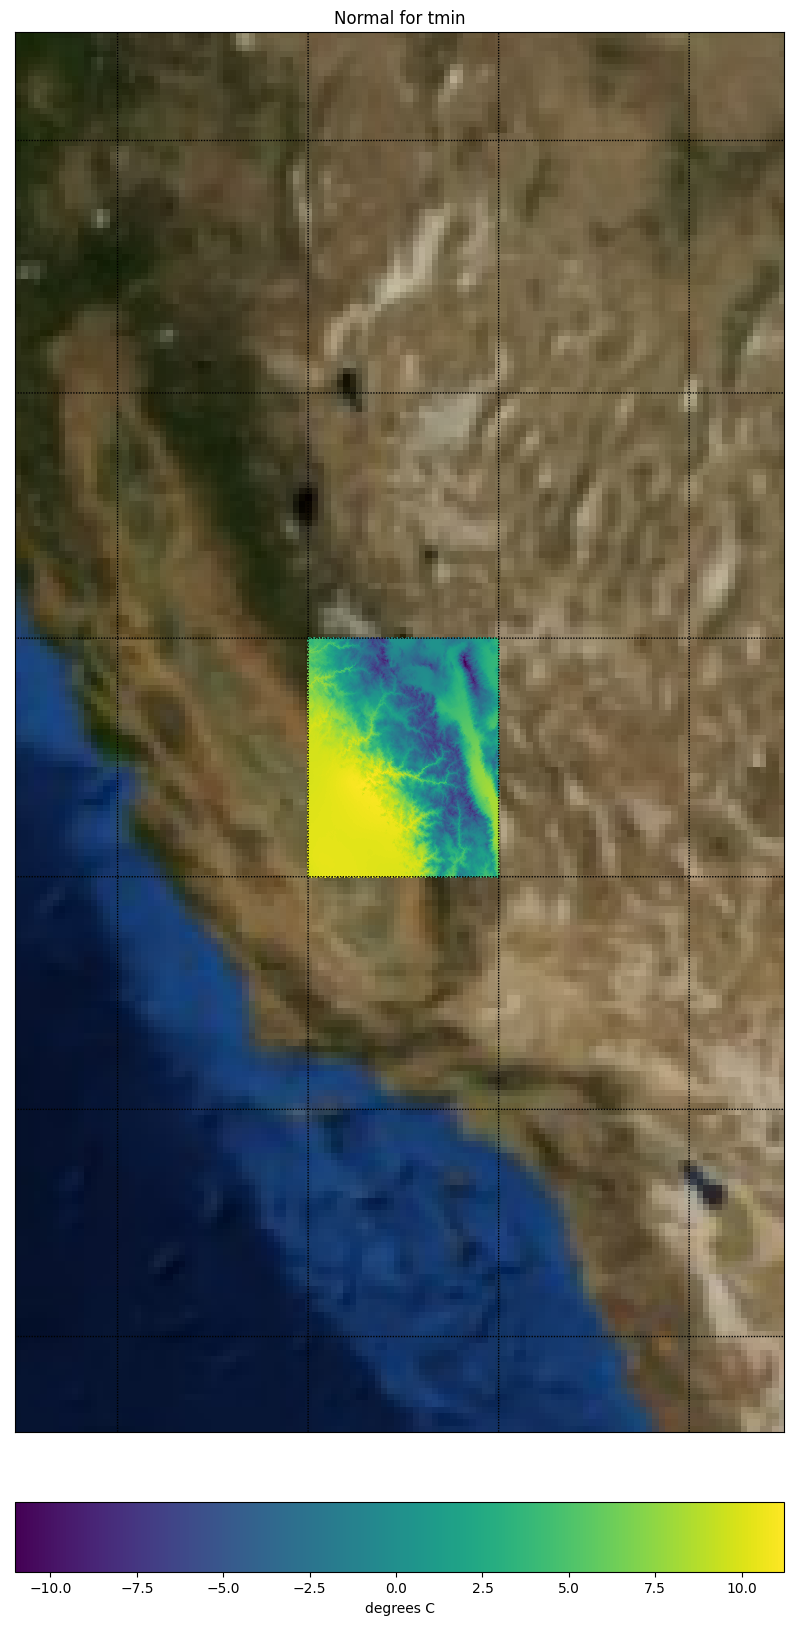

In [17]:
title = "Normal for " + curr_var
plot_tile(normal_data_masked, title)

### 8. Calculating an Anomaly
Now that we have the normalized data over the years 1981 to 2010, let's calculate an anomaly. Say for example we are interested in how the calculated normal deviates from the year 1990. 
<br>

We can use our `get_data()` function to retreive the data for 1990 . Recall that the return type of `get_data()` is `(lat, lon, data, units)`. But we only need the actual data for 1990 since we are plotting the same variable over the same area.

In [18]:
_, _, data_1990, _ = get_data(1990,1990)

working on year 1990 
download complete.
Processing Time:  6.308028936386108 seconds


In [19]:
data_1990.shape

(365, 246, 214)

Now that we have the data for 1990, we will need to go through the process of averaging and masking data once again.

In [20]:
mean_anom_data = np.mean(data_1990, axis=0)

In [21]:
mean_anom_data.shape

(246, 214)

In [22]:
anom_masked = np.ma.masked_where(mean_anom_data < -9000, mean_anom_data)

In [23]:
anom_masked.shape

(246, 214)

An anomaly is a comparison bewteen a subset of the data with the Normal data. In this case, we will simply calculate the difference between the two, but a number of statistics can be used to calculate a comparison.

In [24]:
diff = np.abs(normal_data_masked - anom_masked)

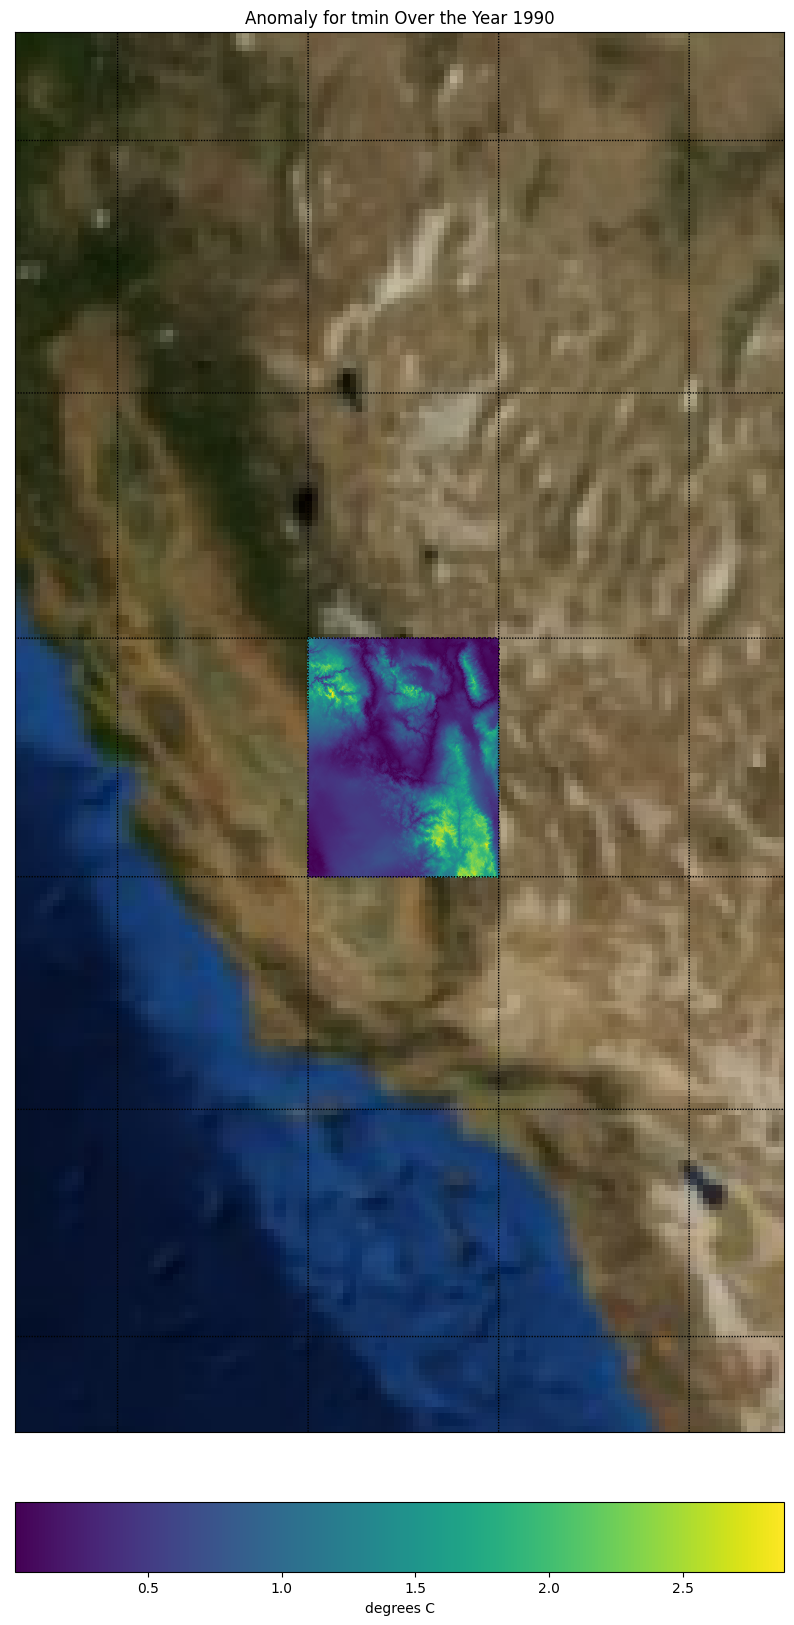

In [25]:
title = "Anomaly for " + curr_var + " Over the Year 1990"
plot_tile(diff, title)

As you can see, this `basemap` shows the absolute difference between 1990 and the Normal for this tile and variable.